## Basic Channel Info EDA

In [53]:
import pandas as pd
channel_data = pd.read_csv('../combined_info.csv', index_col = 0)

In [ ]:
channel_data.head()

In [ ]:
import sweetviz as sv
feature_config = sv.FeatureConfig(force_text=['playlistId','channelName'])
channel_info_report = sv.compare_intra(channel_data, channel_data['popUnpop'] == 0, ['Unpopular','Popular'], target_feat = 'views', feat_cfg=feature_config, pairwise_analysis='on')

# analyze(channel_data, target_feat='views',pairwise_analysis = 'on', feat_cfg=feature_config)
channel_info_report.show_notebook()

### Video Data EDA

In [54]:
import pandas as pd
from dateutil import parser
import seaborn as sns
import matplotlib.pyplot as plt
import isodate
import datetime

In [55]:
vid_data = pd.read_csv('../combined_vid.csv', index_col = 0)
viddf = vid_data.copy()

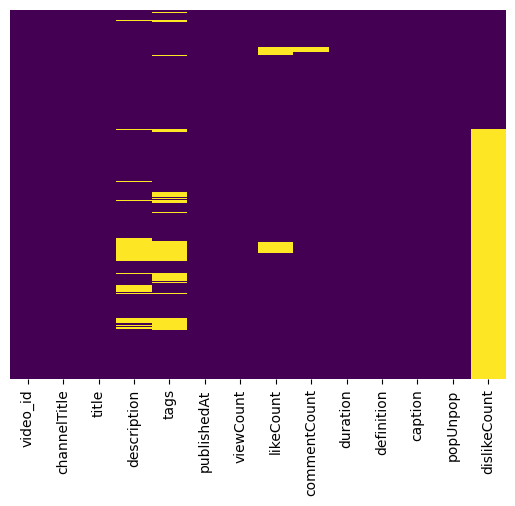

In [56]:
sns.heatmap(viddf.isnull(),yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [57]:
# Drop Dislike count since it has many missing values
viddf.drop(['dislikeCount'],axis = 1, inplace=True)
# viddf.drop(['favouriteCount'],axis = 1, inplace=True)

In [58]:
import pandas as pd
from dateutil import parser

# Assume 'viddf' is your DataFrame

# Define a function to parse 'publishedAt' and handle errors
def parse_published_at(x):
    try:
        parsed_value = parser.parse(x)
        # Convert parsed_value to timezone-naive if it's timezone-aware
        return parsed_value.replace(tzinfo=None) if parsed_value.tzinfo else parsed_value
    except Exception as e:
        # print(f"Error parsing value: {x}, Error: {e}")
        return None

# Apply the parsing function to the 'publishedAt' column
viddf['publishedAt'] = viddf['publishedAt'].apply(parse_published_at)

# Drop rows with parsing errors and show the count
num_dropped_rows = viddf['publishedAt'].isna().sum()
viddf.dropna(subset=['publishedAt'], inplace=True)

# Create publish day (in the week) column
viddf['publishDayName'] = viddf['publishedAt'].apply(lambda x: x.strftime("%A"))

# Convert 'publishedAt' column to datetime
viddf['publishedAt'] = pd.to_datetime(viddf['publishedAt'])

# Extract year, month, and time into separate columns
viddf['publishingYear'] = viddf['publishedAt'].dt.year
viddf['publishingMonth'] = viddf['publishedAt'].dt.month
viddf['publishingTime'] = viddf['publishedAt'].dt.time

# Get month name
viddf['publishingMonthName'] = viddf['publishedAt'].dt.strftime("%B")

# Dropping the 'publishedAt' column
viddf.drop(['publishedAt'], axis=1, inplace=True)

# Print the count of dropped rows
print(f"Number of rows dropped due to parsing errors: {num_dropped_rows}")


Number of rows dropped due to parsing errors: 45


In [59]:
# # Create publish day (in the week) column
# viddf['publishedAt'] =  viddf['publishedAt'].apply(lambda x: parser.parse(x))
# viddf['publishDayName'] = viddf['publishedAt'].apply(lambda x: x.strftime("%A"))

# # Convert publishedAt column to datetime
# viddf['publishedAt'] =(pd.to_datetime(viddf['publishedAt']))


# # Extract year, month, and time into separate columns
# viddf['publishingYear'] = viddf['publishedAt'].dt.year
# viddf['publishingMonth'] = viddf['publishedAt'].dt.month
# viddf['publishingTime'] = viddf['publishedAt'].dt.time

# # Get month name
# viddf['publishingMonthName'] = viddf['publishedAt'].dt.strftime("%B")

# # Dropping the published At column
# viddf.drop(['publishedAt'],axis = 1, inplace = True)

In [60]:
# Doing some necessary data manipulations
cols = ['viewCount', 'likeCount', 'commentCount']
viddf[cols] = viddf[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [61]:
#viewCount is basically a target feature and shouldn't have nan values to sucsessfully generate a report
viddf.dropna(axis = 0, subset = ['viewCount'], inplace = True) 
viddf.dropna(axis = 0, subset = ['likeCount'], inplace = True)

#### Enriching data

I want to enrich the data for further analyses, for example:
- convert video duration to seconds instead of the current default string format
- calculate number of tags for each video
- calculate comments and likes per 1000 view ratio
- calculate title character length

In [62]:
# convert duration to seconds
viddf['durationSecs'] = viddf['duration'].apply(lambda x: isodate.parse_duration(x))
viddf['durationSecs'] = viddf['durationSecs'].astype('timedelta64[s]')
viddf.drop(['duration'],axis = 1, inplace=True) # Remove duration since we got it in secs now

In [63]:
# Add number of tags
viddf['tagsstr'] = viddf.tags.apply(lambda x: 0 if x is None else str((x))) #tags were not in proper format so converting them to str
viddf['tagsCount'] = viddf.tagsstr.apply(lambda x: 0 if (x == 0 or x =='nan') else len(eval(x)))
viddf.drop(['tags'],axis = 1, inplace=True) # Remove tags since we got tagstr now

In [64]:
# Comments and likes per 1000 view ratio
viddf['likeRatio'] = viddf['likeCount']/ viddf['viewCount'] * 1000
viddf['commentRatio'] = viddf['commentCount']/ viddf['viewCount'] * 1000

In [65]:
# Title character length
viddf['titleLength'] = viddf['title'].apply(lambda x: len(x))

In [66]:
viddf.columns

Index(['video_id', 'channelTitle', 'title', 'description', 'viewCount',
       'likeCount', 'commentCount', 'definition', 'caption', 'popUnpop',
       'publishDayName', 'publishingYear', 'publishingMonth', 'publishingTime',
       'publishingMonthName', 'durationSecs', 'tagsstr', 'tagsCount',
       'likeRatio', 'commentRatio', 'titleLength'],
      dtype='object')

In [67]:
viddf.describe()

,viewCount,likeCount,commentCount,popUnpop,publishingYear,publishingMonth,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
count,2.972600e+04,2.972600e+04,2.962100e+04,29726.000000,29726.000000,29726.000000,29726.000000,29726.000000,2.972200e+04,29609.000000,29726.000000
mean,5.502155e+06,1.426480e+05,3.660550e+03,0.682668,2019.998722,7.595472,625.540369,17.377750,inf,1.388528,54.817433
std,3.807298e+07,7.832486e+05,1.714806e+04,0.465446,3.389570,3.440698,1592.680749,12.005498,NaN,2.586492,21.343124
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2007.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000
25%,2.552175e+04,3.450000e+02,7.000000e+00,0.000000,2017.000000,5.000000,60.000000,6.000000,8.734331e+00,0.165492,39.000000
50%,1.880435e+05,2.693500e+03,1.210000e+02,1.000000,2022.000000,8.000000,341.000000,19.000000,1.925122e+01,0.693481,52.000000
75%,2.050362e+06,5.156625e+04,1.161000e+03,1.000000,2023.000000,11.000000,675.000000,26.000000,3.764250e+01,1.821296,70.000000
max,2.451315e+09,4.178985e+07,1.029124e+06,1.000000,2023.000000,12.000000,86402.000000,68.000000,inf,250.000000,100.000000


                                             |                                                           | [  …


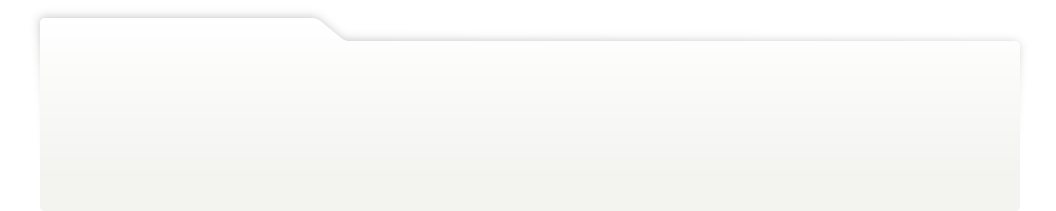
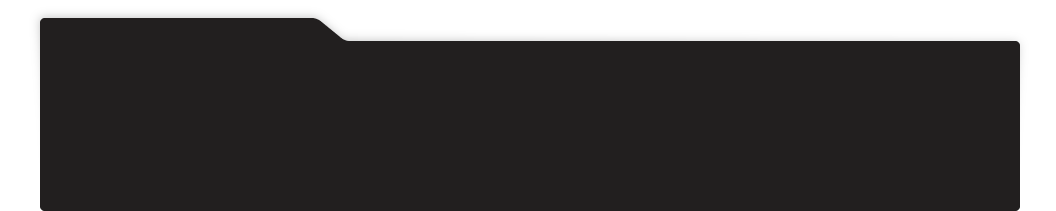
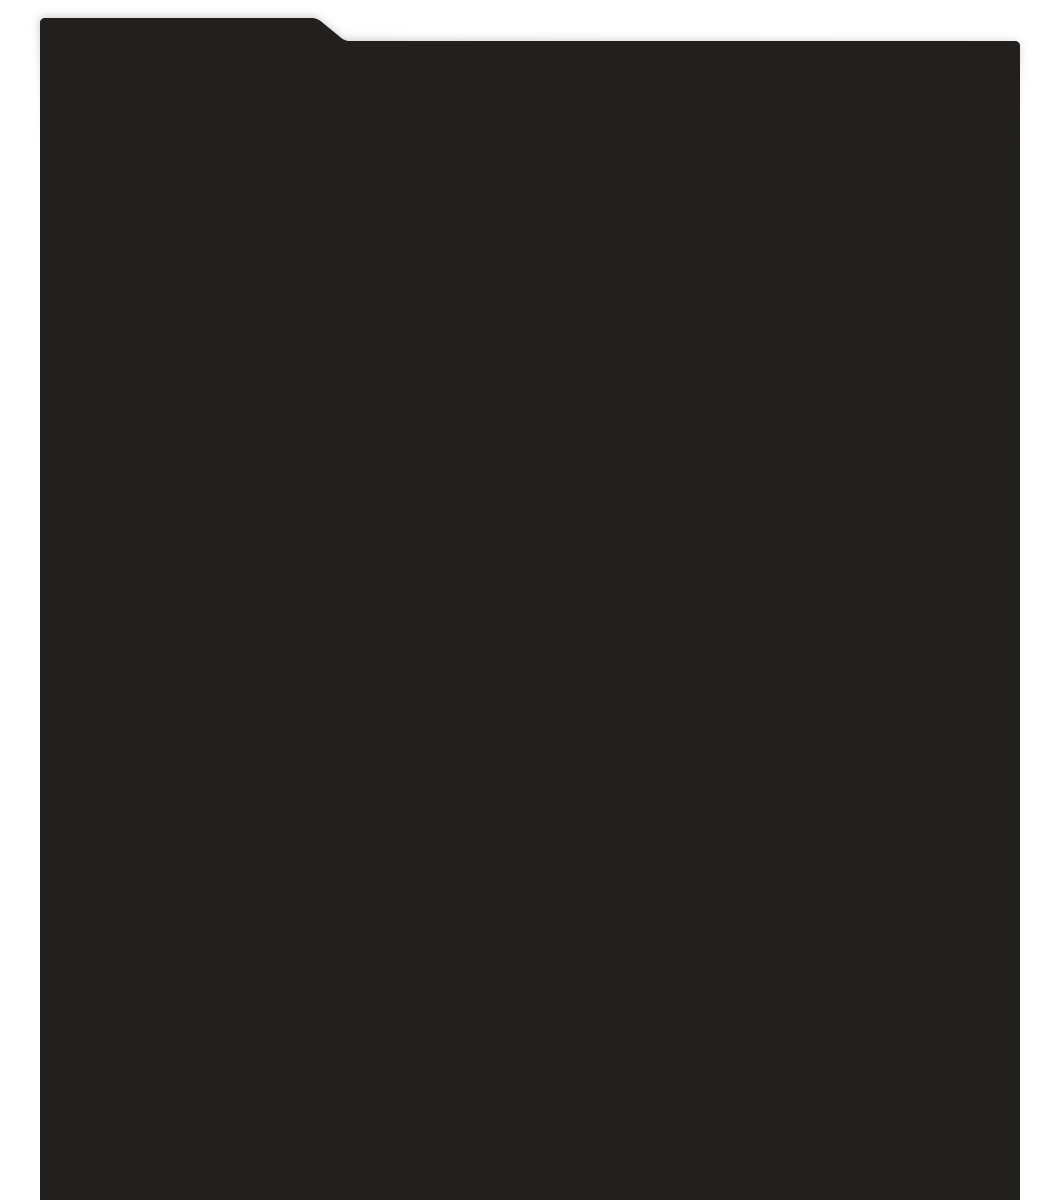
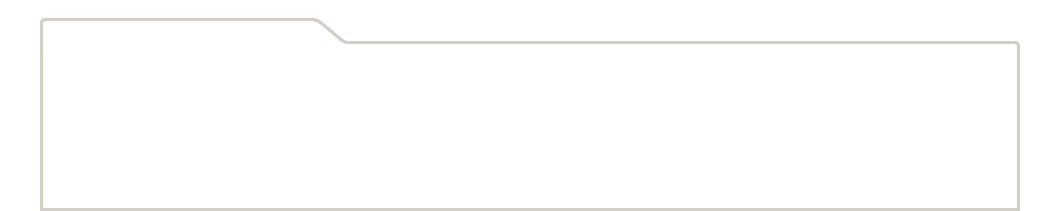
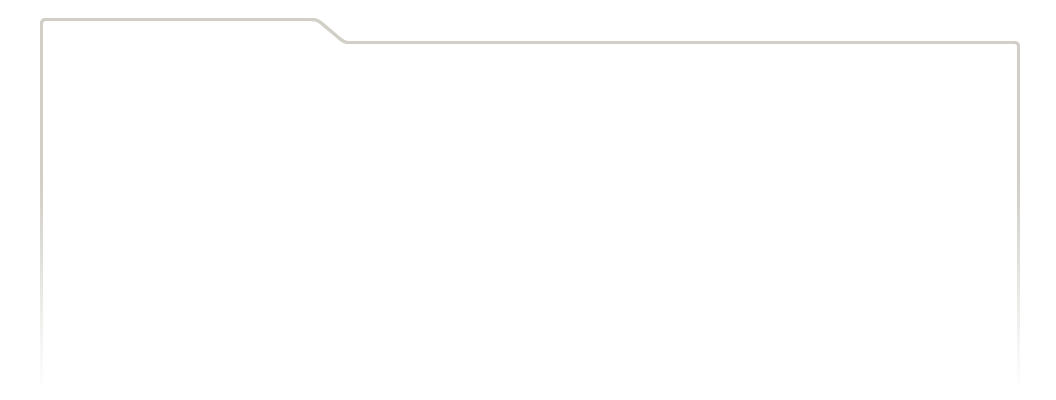
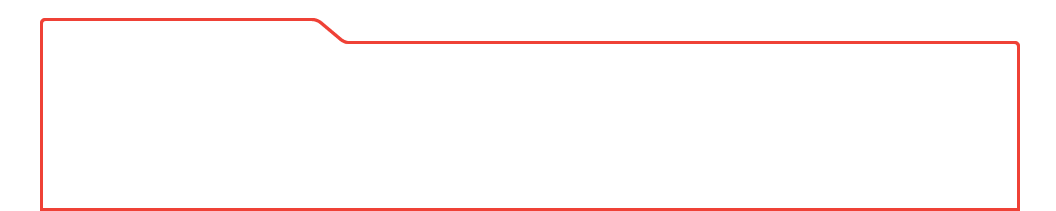
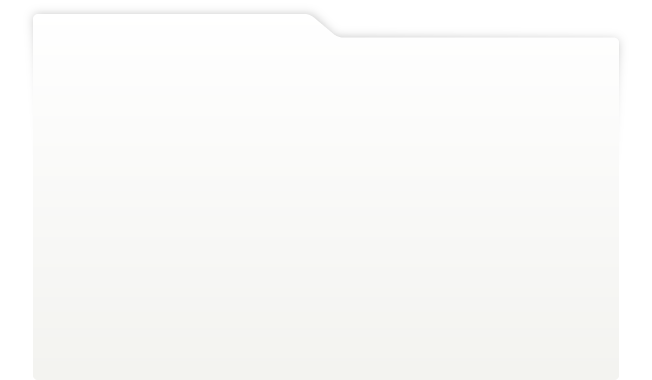
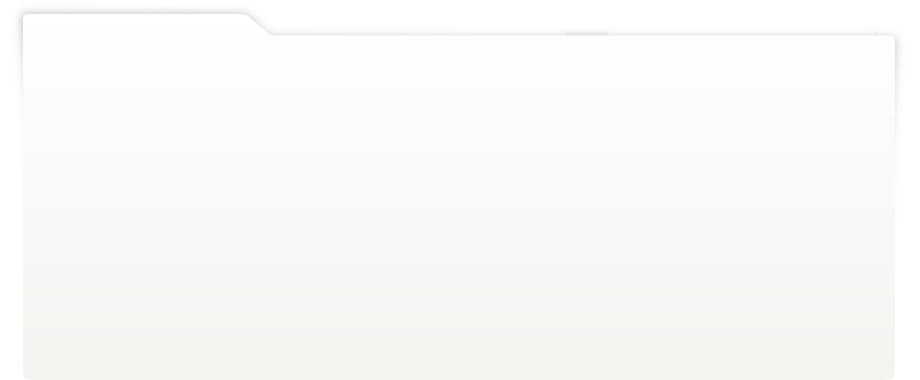
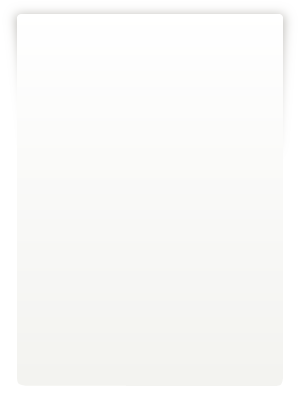
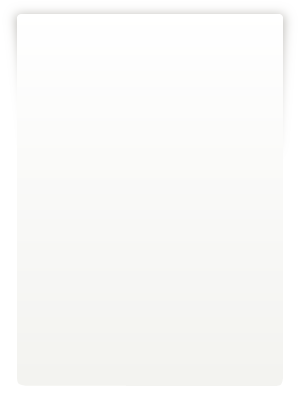
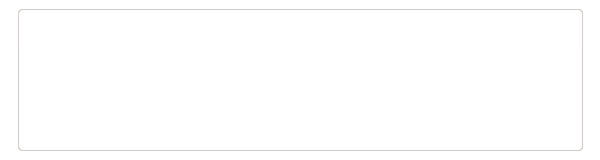
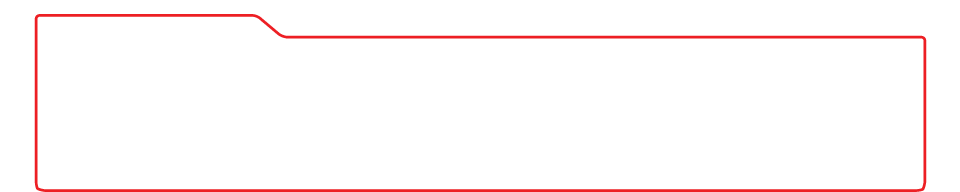
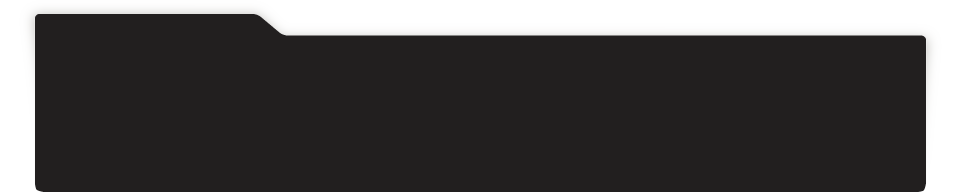
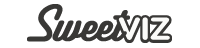
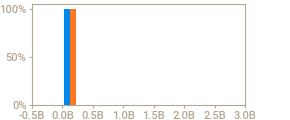
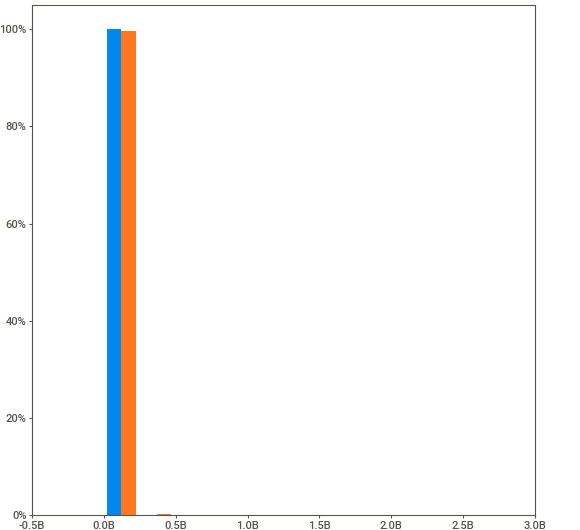
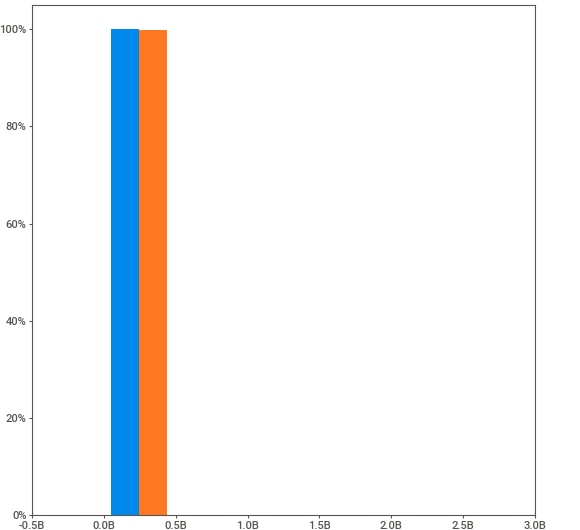
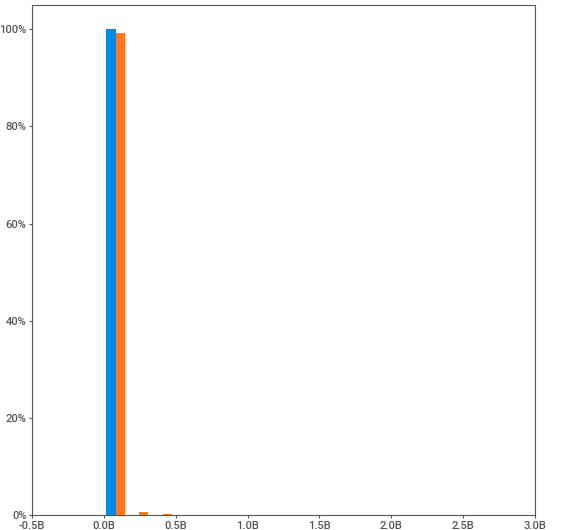
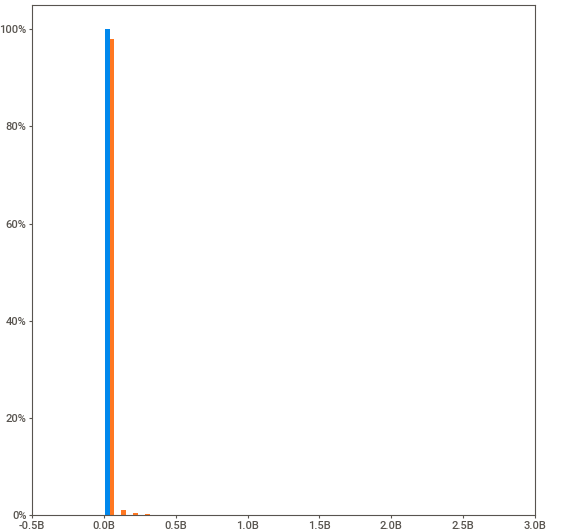
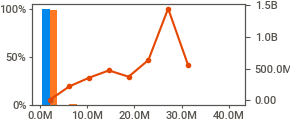
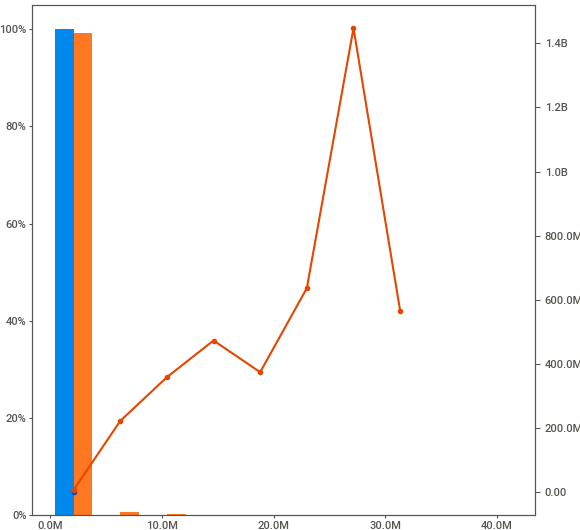
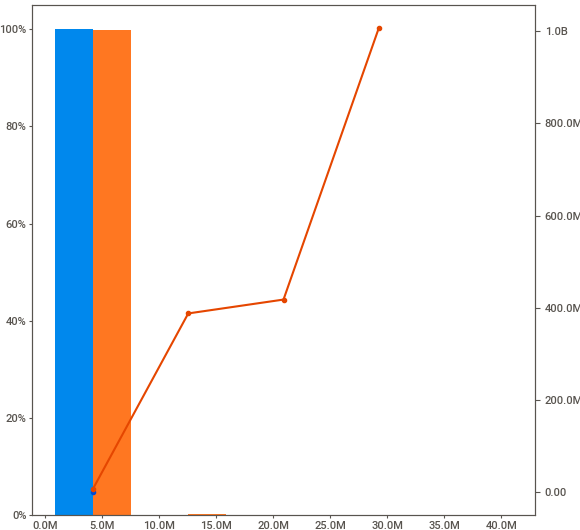
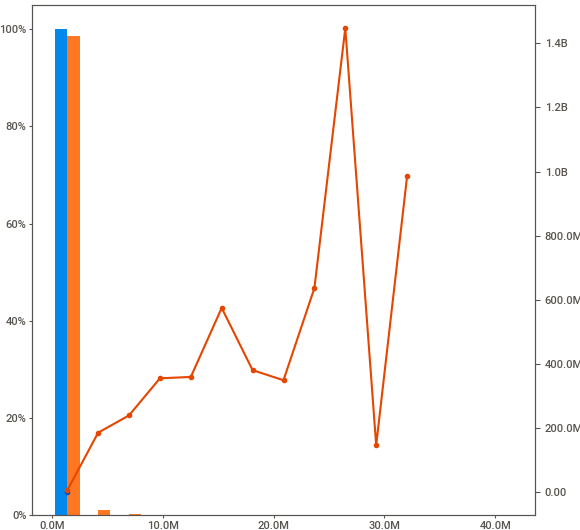
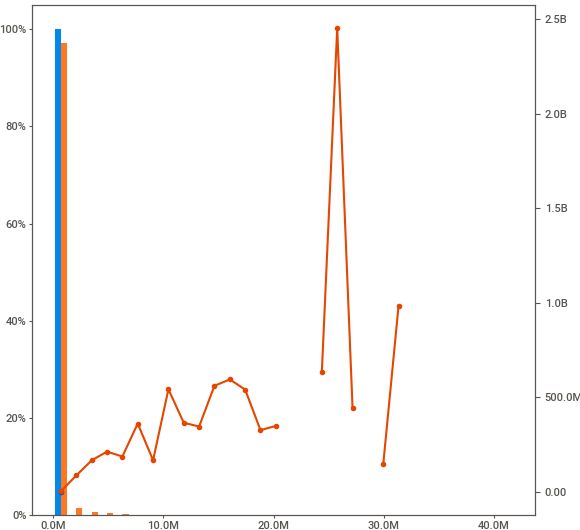
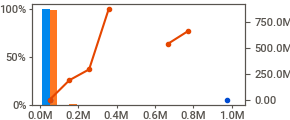
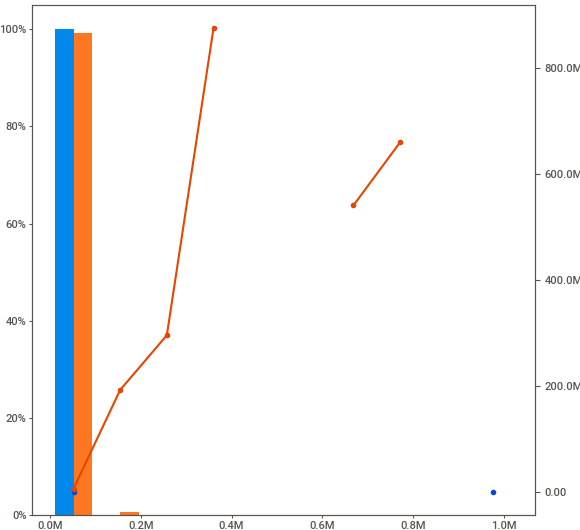
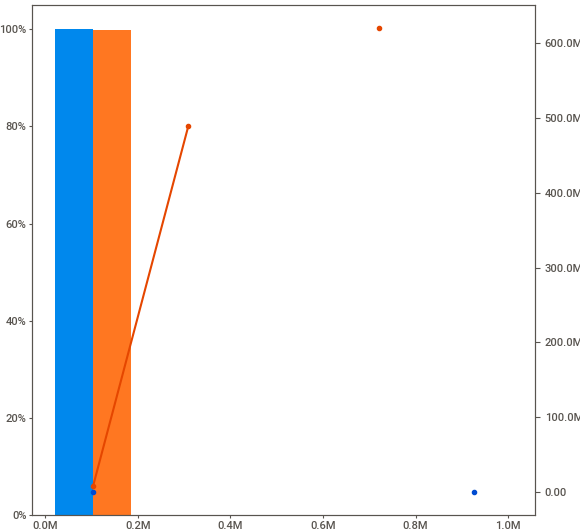
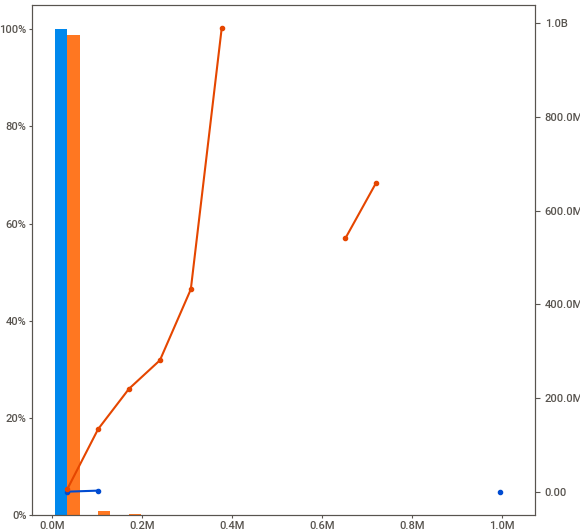
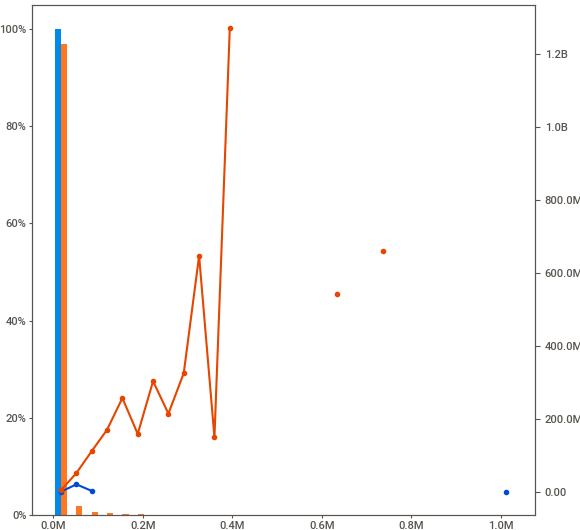
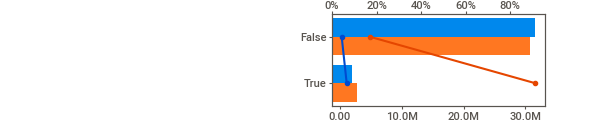
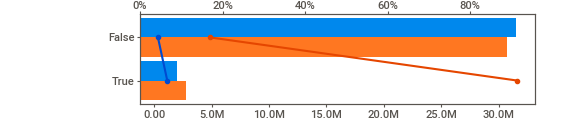
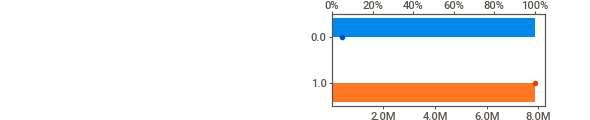
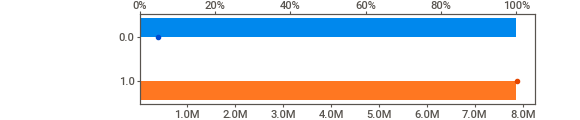
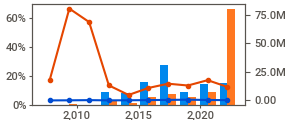
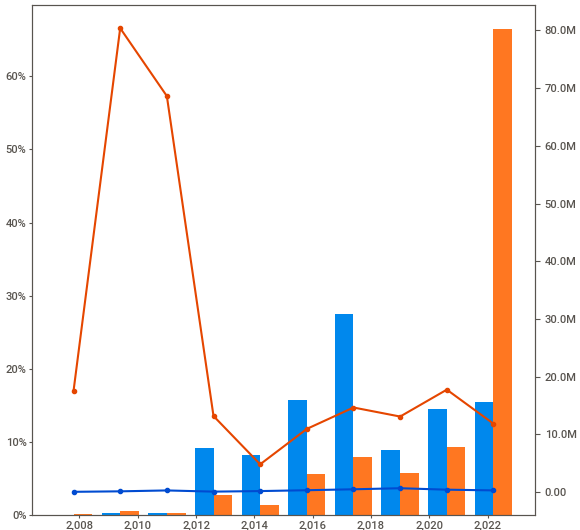
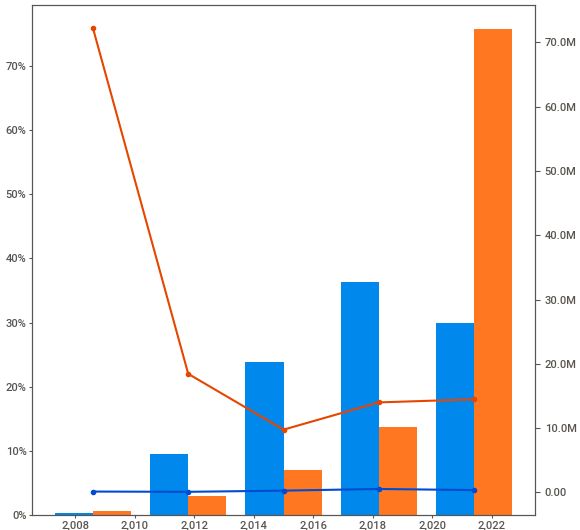
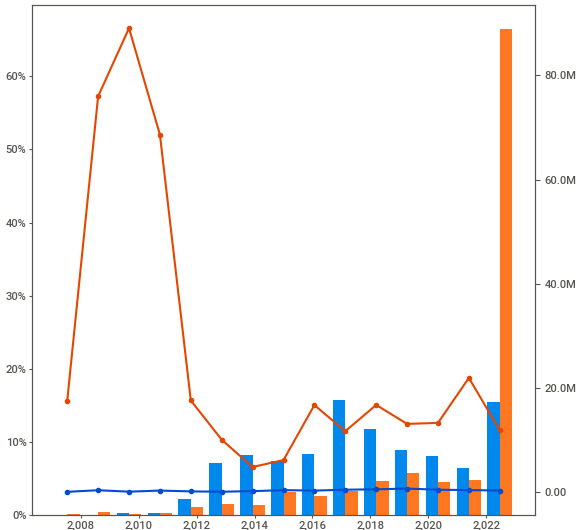
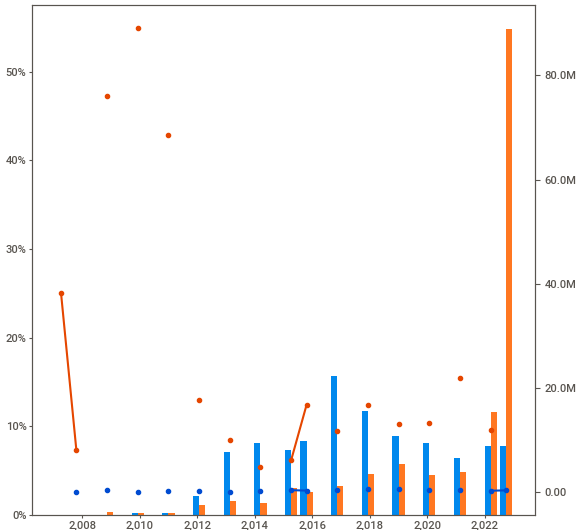
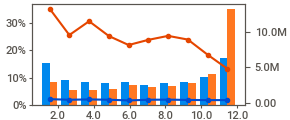
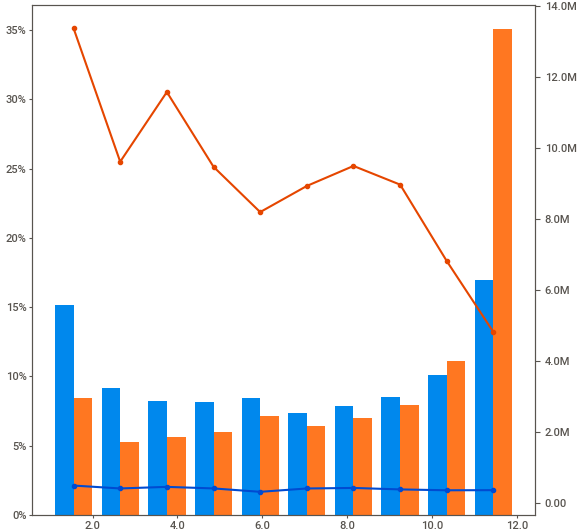
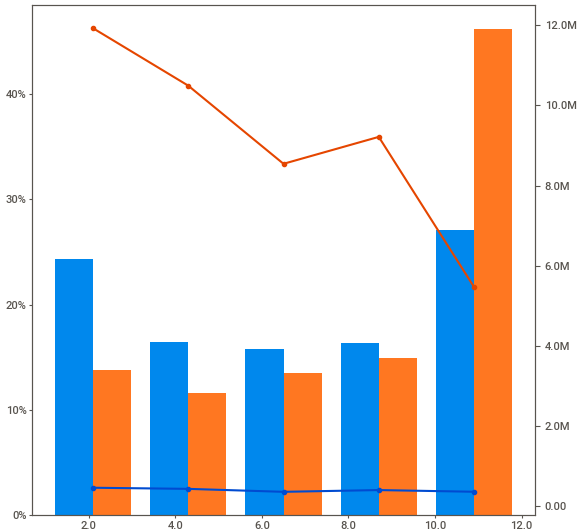
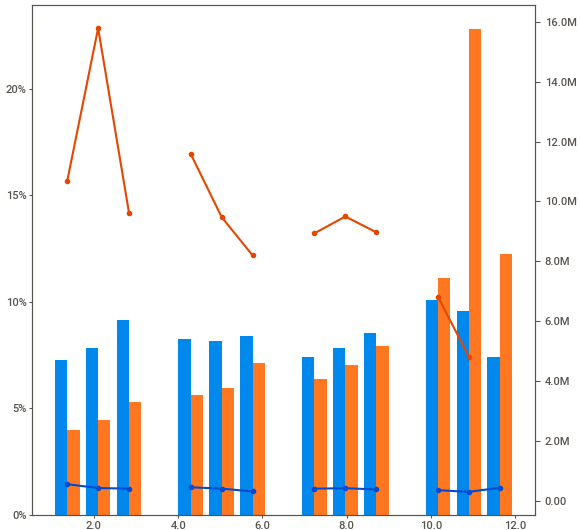
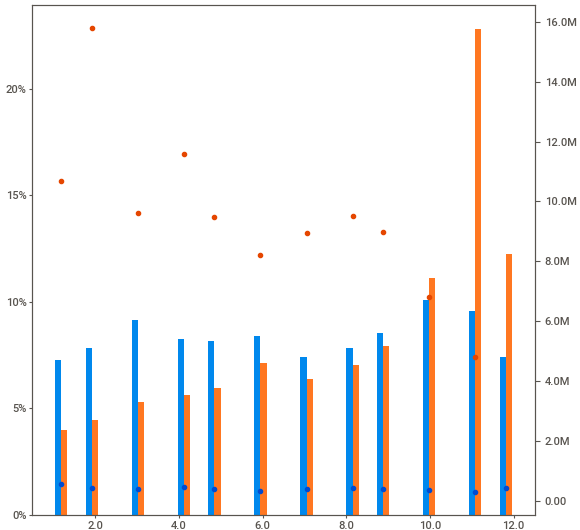
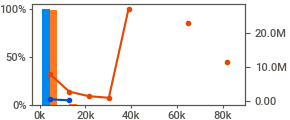
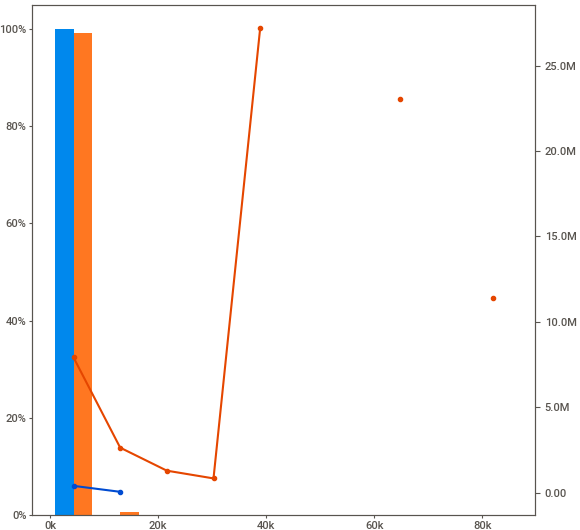
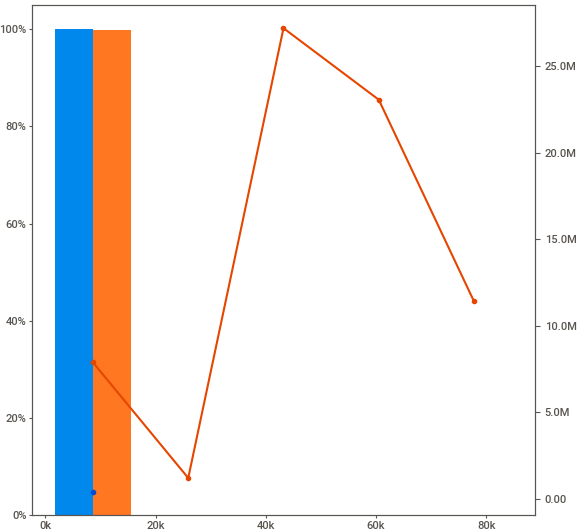
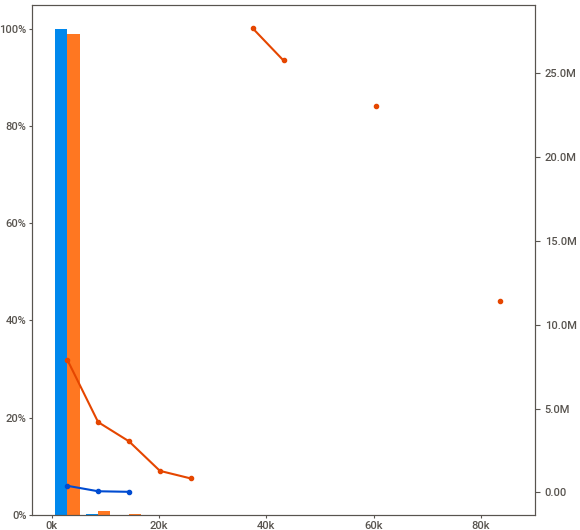
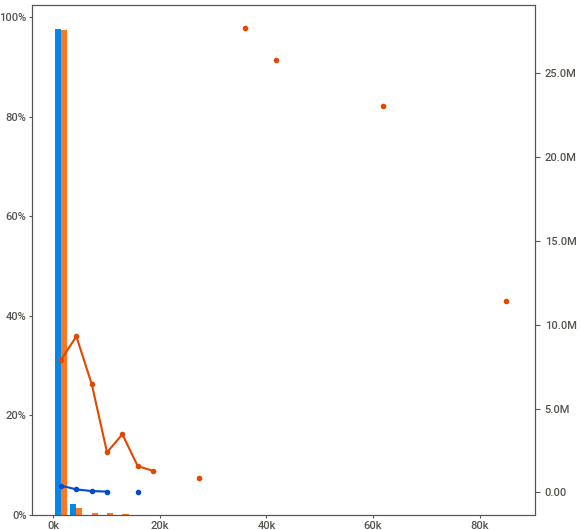
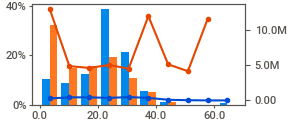
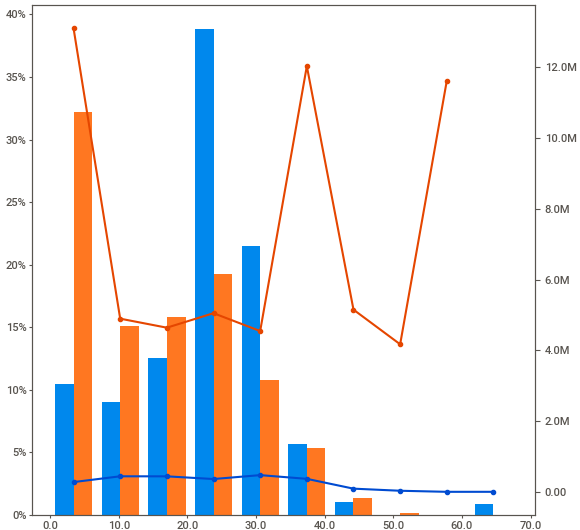
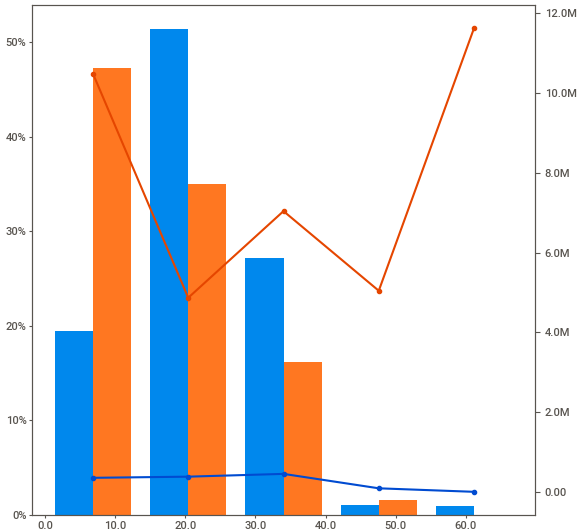
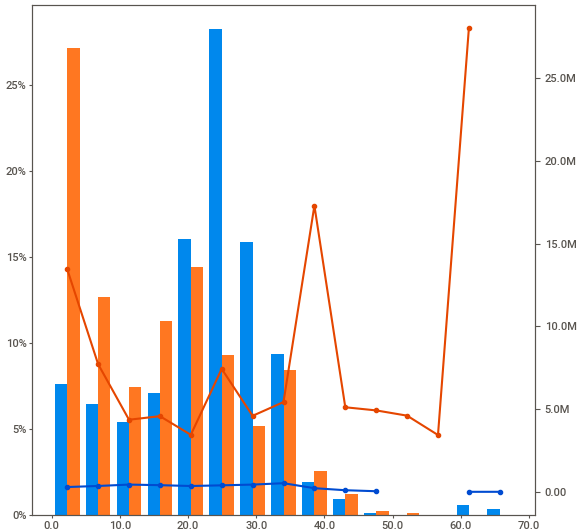
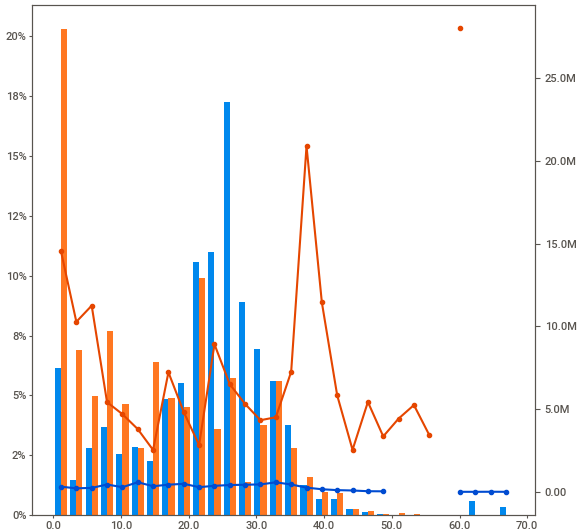
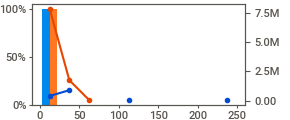
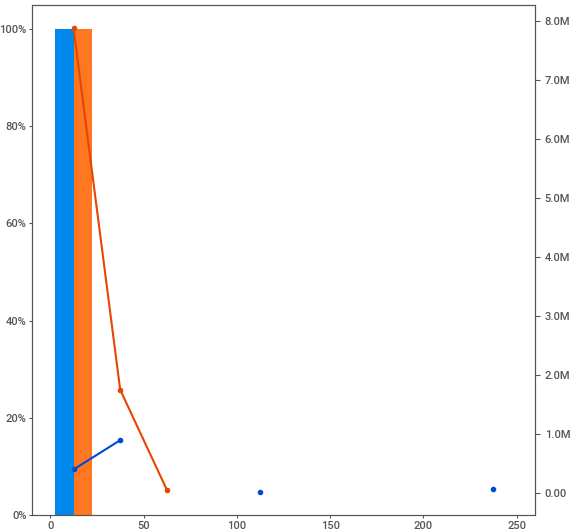
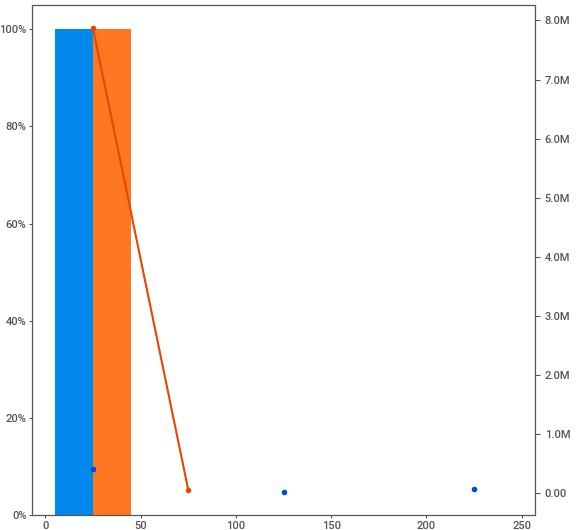
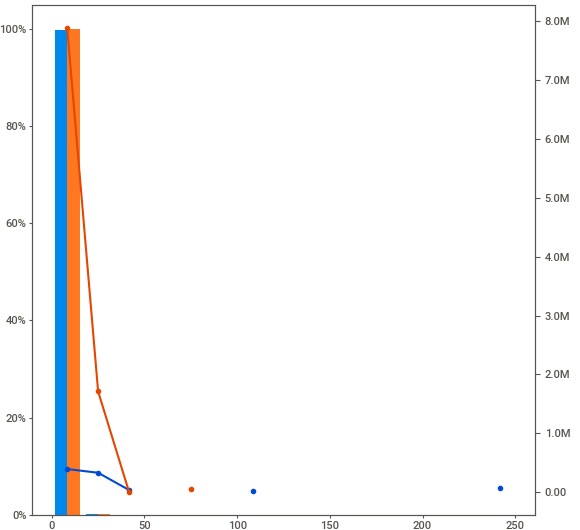
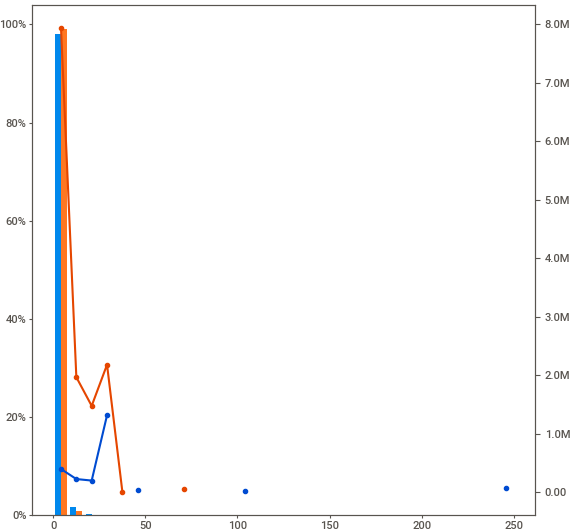
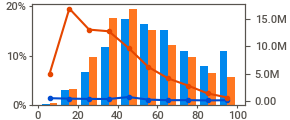
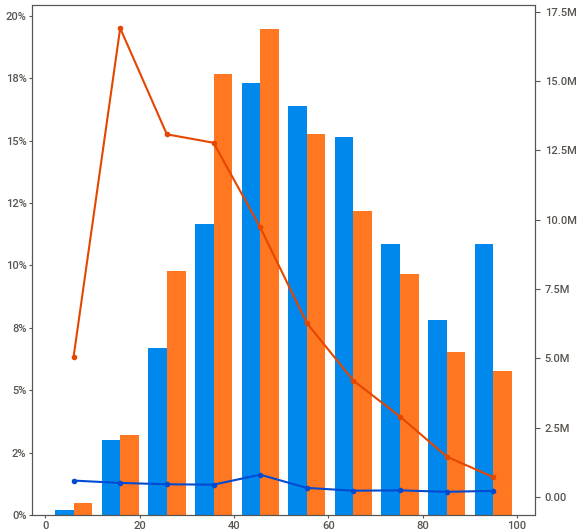
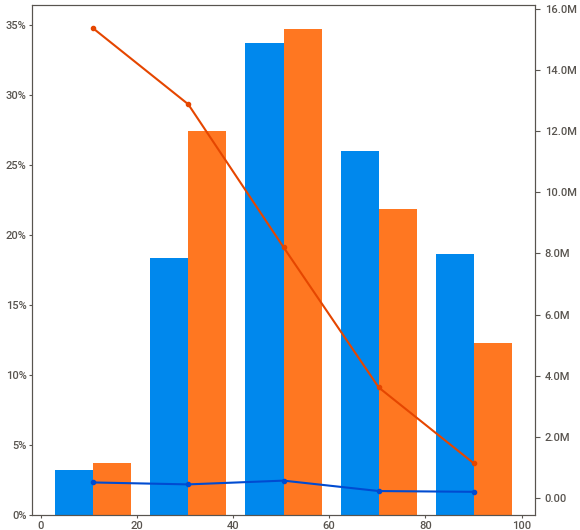
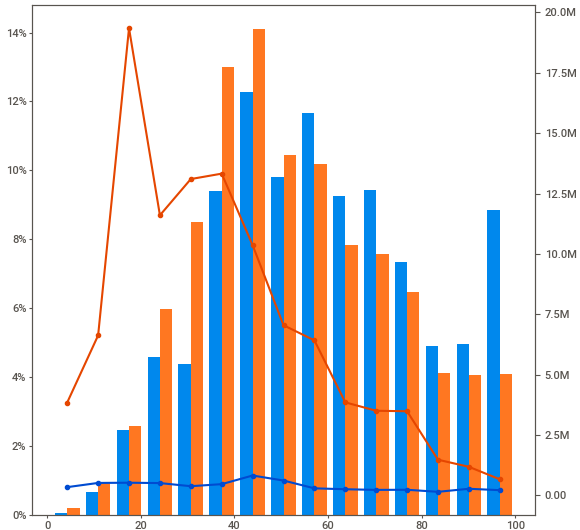
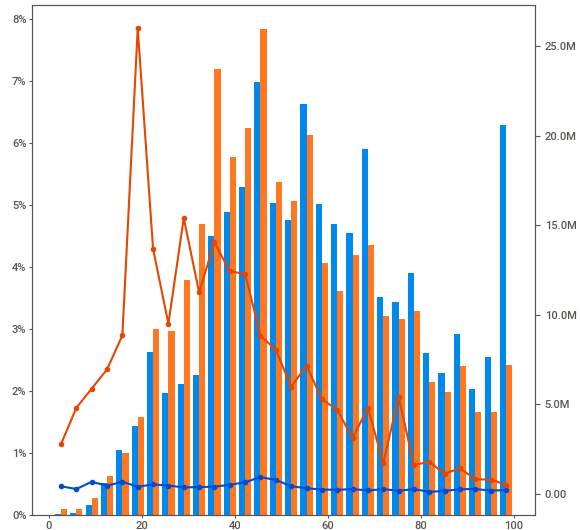
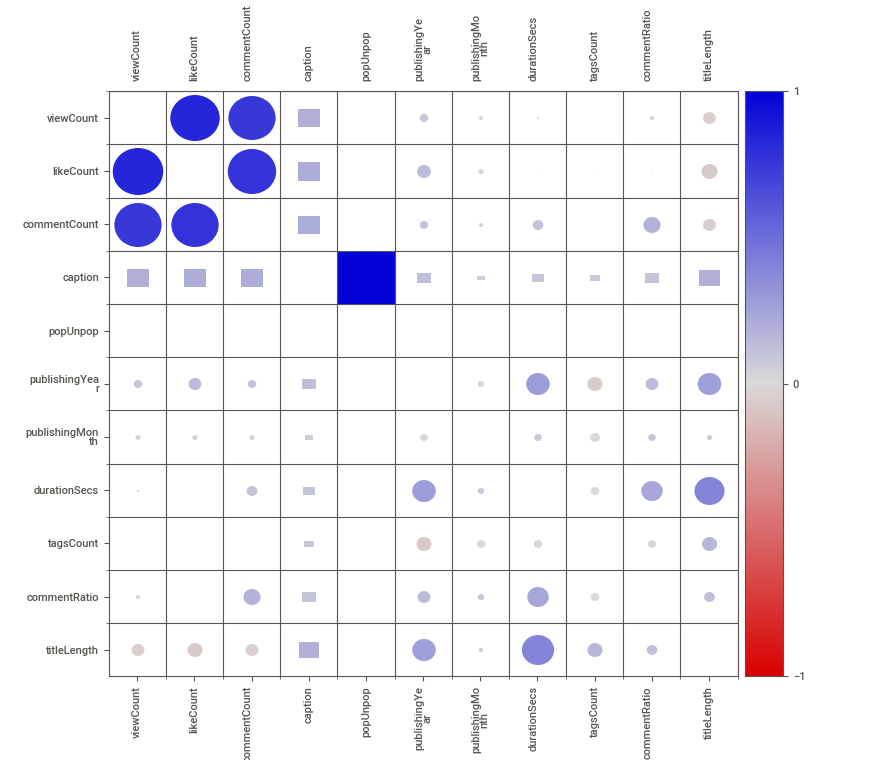
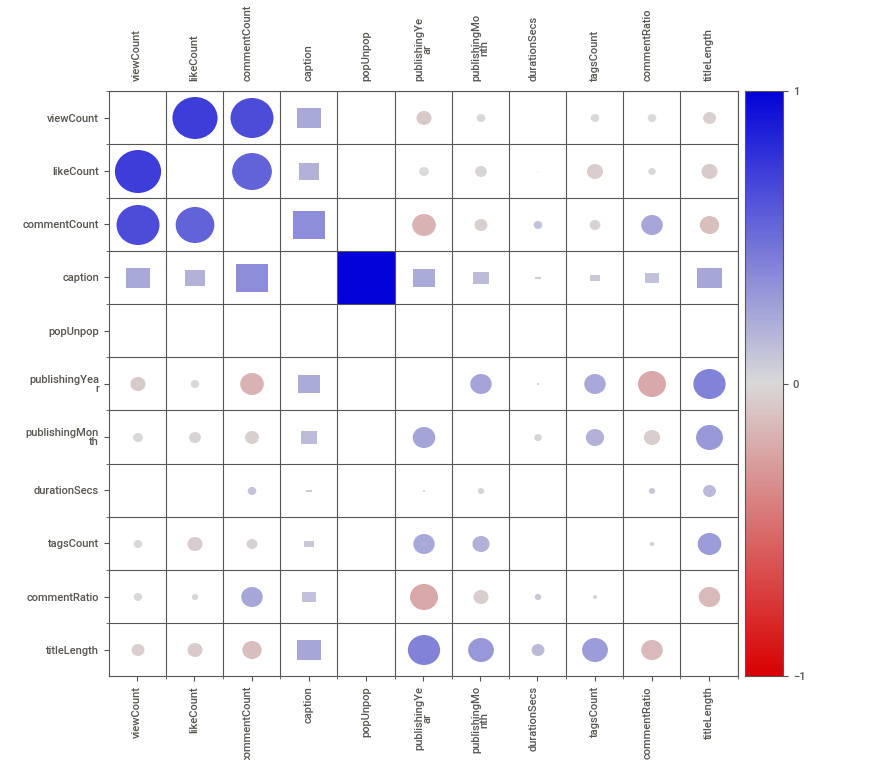

In [68]:
import sweetviz as sv
feature_config = sv.FeatureConfig(skip ='likeRatio',force_text=['video_id','channelTitle','title','description', 'definition','publishDayName','publishingMonthName','tagsstr'])
channel_info_report = sv.compare_intra(viddf, viddf['popUnpop'] == 0, ['Unpopular','Popular'], target_feat = 'viewCount', feat_cfg=feature_config, pairwise_analysis='on')
channel_info_report.show_notebook()

### Comment Data EDA